# File and libraries

In [1]:
import pandas as pd
import numpy as np

filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [3]:
%run "data_functions.py"


dslabs_functions lodaded
data_functions loaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    df = df.groupby('day').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)

    # data=data.sample(frac=0.05, replace=False)
    # test=test.sample(frac=0.05, replace=False)
    # train=train.sample(frac=0.05, replace=False)
    
    
else:
    # df=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    df=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 

 
target='is_purchase'
target_metric_2='precision'
target_metric='f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21185 entries, 0 to 21184
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code_lvl_1  21185 non-null  float64
 1   category_code_lvl_2  21185 non-null  float64
 2   price                21185 non-null  float64
 3   is_purchase          21185 non-null  int64  
 4   activity_in_session  21185 non-null  float64
 5   week_of_month        21185 non-null  int64  
 6   day                  21185 non-null  int64  
 7   brand_value          21185 non-null  float64
 8   product_category     21185 non-null  int64  
 9   day_of_week_sin      21185 non-null  float64
 10  day_of_week_cos      21185 non-null  float64
 11  hour_sin             21185 non-null  float64
 12  hour_cos             21185 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 2.3 MB


# Distribution Check

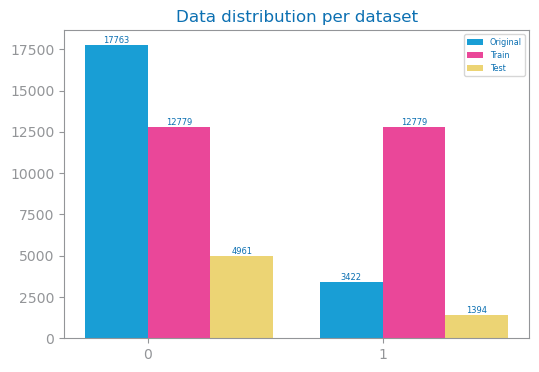

In [7]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [5]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=25558 Test#=6355
Labels=[0, 1]


## recall evaluation

In [38]:
k_eval=90

## recall study

KNN best with k=9 and chebyshev


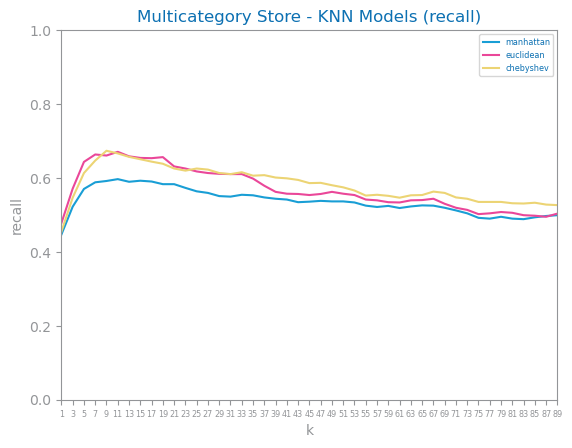

In [39]:
best_model_recall, recall_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='recall',file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["metric"]}_study.png')
show()

## recall best model

<Figure size 640x480 with 0 Axes>

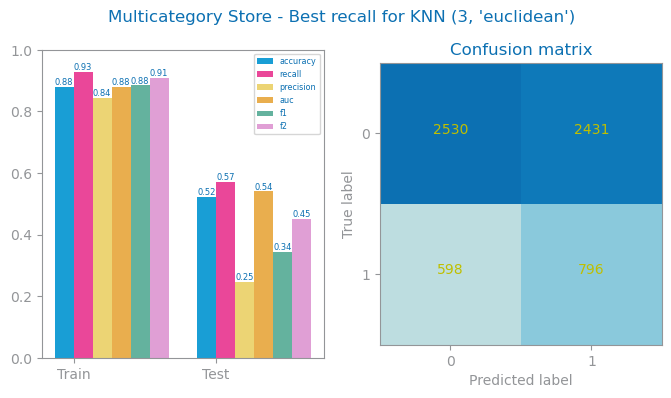

In [22]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

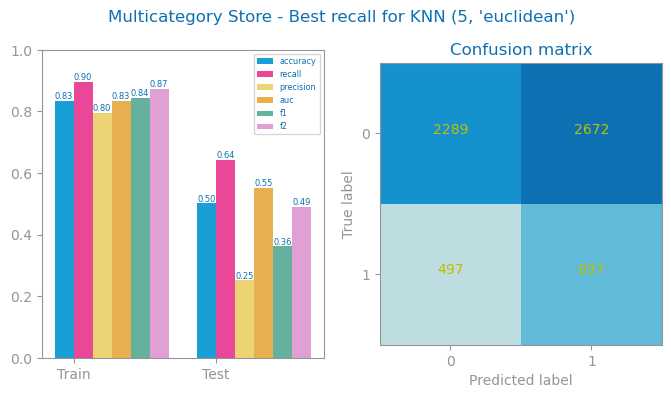

In [14]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

## recall overfitting

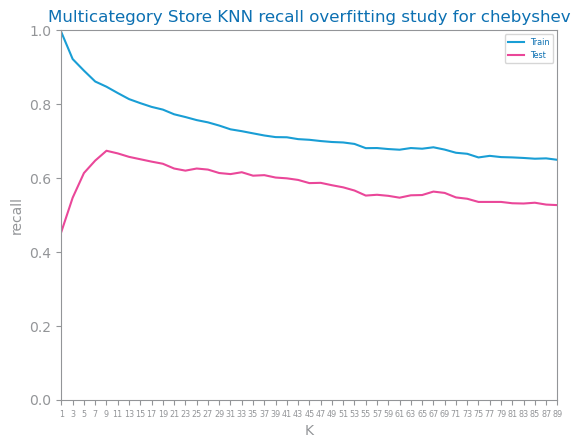

In [41]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = recall_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = recall_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {recall_params['metric']} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{recall_params['metric']}_overfitting.png")
show()

# precision evaluation

## precision study

In [62]:
k_eval=100

KNN best with k=5 and manhattan


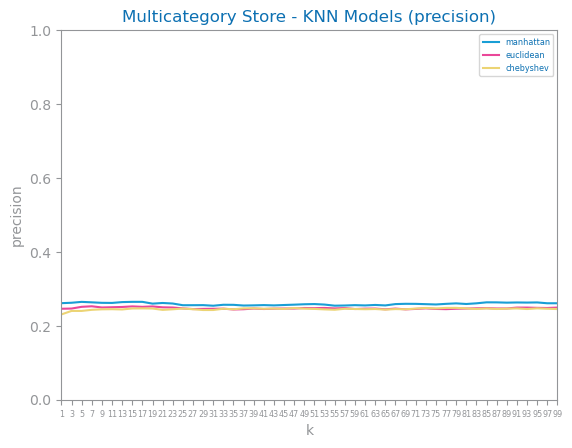

In [63]:
best_model_prec, prec_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='precision', file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{prec_params["metric"]}_study.png')
show()

## precision best model

<Figure size 640x480 with 0 Axes>

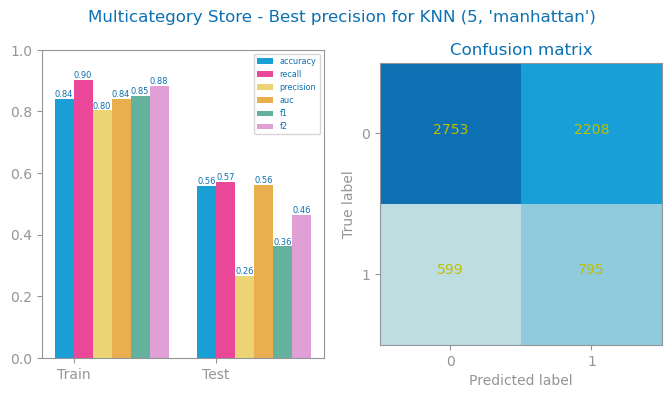

In [47]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn__{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## precision overfitting

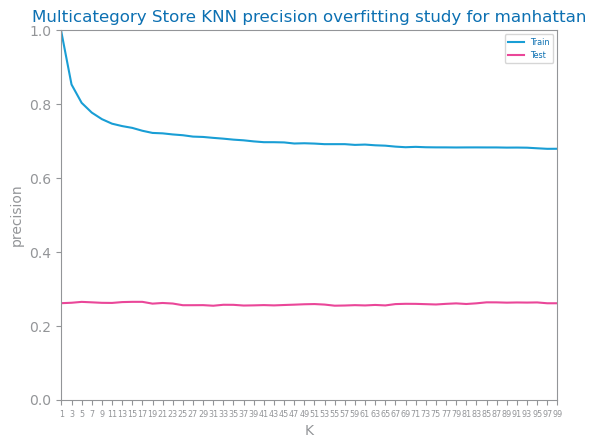

In [65]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = prec_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = prec_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {eval_metric} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{eval_metric}_overfitting.png")
show()

# f2 evaluation

## f2 Study

### k max = 100

In [9]:
k_eval = 100

KNN best with k=11 and euclidean


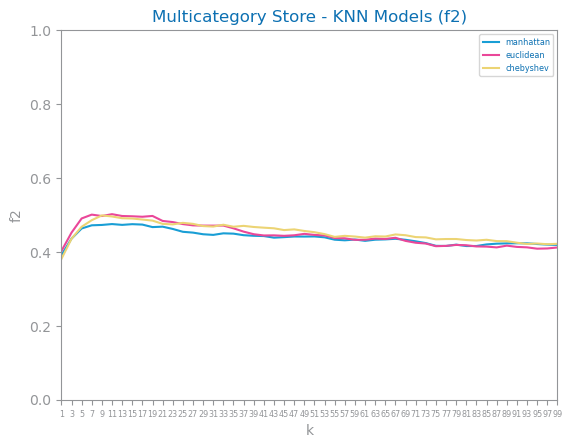

In [10]:
best_model_f2, f2_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='f2', file_tag=file_tag)


savefig(f'images/{file_tag}_knn_{f2_params["metric"]}_study.png')
show()

### k max = 20

In [7]:
k_eval = 20

KNN best with k=11 and euclidean


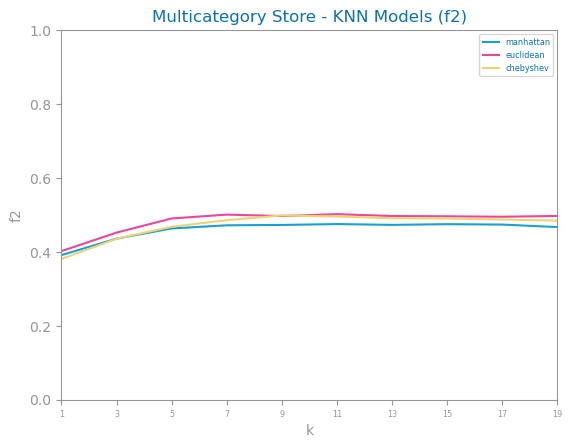

In [8]:
best_model_f2, f2_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='f2', file_tag=file_tag)


savefig(f'images/{file_tag}_knn_{f2_params["metric"]}_study.png')
show()

### k max = 80 (the best one)

In [92]:
k_eval = 80

KNN best with k=11 and euclidean


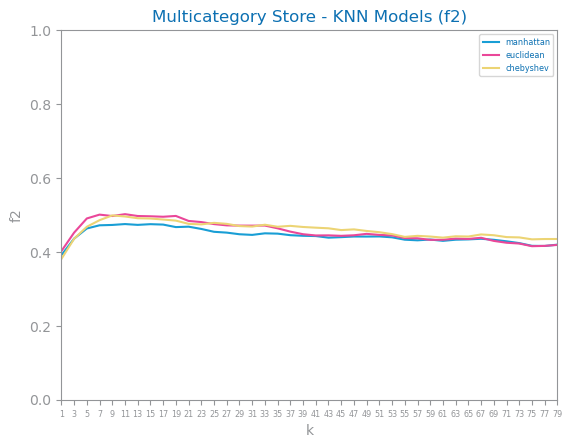

In [93]:
best_model_f2, f2_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='f2', file_tag=file_tag)


savefig(f'images/{file_tag}_knn_{f2_params["metric"]}_study.png')
show()

## f2 best model

<Figure size 640x480 with 0 Axes>

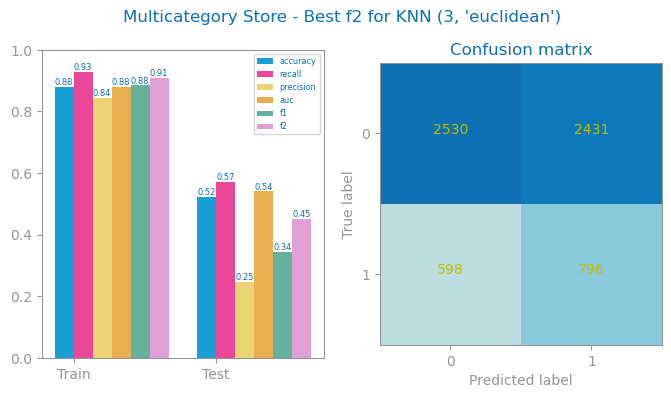

In [75]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Overfitting

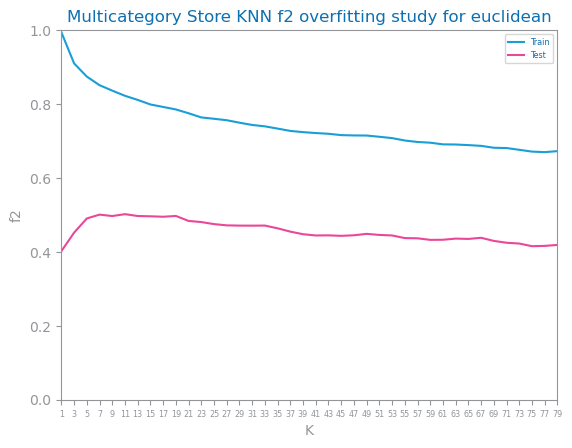

In [95]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = f2_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = f2_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {f2_params['metric']} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(target_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{f2_params['metric']}_overfitting.png")
show()

# Analysis

Precision/recall/ f2 study:
- recall KNN best with K=5
- Precision KNN best with  K=5
- f2 KNN best with K=3

Logic for evaluation:
- Our goal is to maximize true positives (high recall) while minimizing false positives (high precision). This approach enables us to effectively identify customers who are likely to purchase, focusing our marketing efforts on those most likely to convert. By reducing false positives, we also avoid unnecessary spending on campaigns targeted at users who are unlikely to buy.

- The F2 score, which places more emphasis on recall than precision, is the best metric to evaluate this balance. During the evaluation phase, we will assess model performance primarily using the F2 score, analyzing precision and recall together. Our objective is to achieve a balanced score that allows us to identify as many potential buyers as possible, while keeping false positives low to optimize our marketing budget.

Dataset used:
- Sample from balancing dataset was used, as running the evaluation on the with complete balancing dataset was too time-consuming.

Precision/recall/ f2 study:
- É percetivel, que com mais k vizinhos,a performance do melhor f2 e precision decresce, o que significa que para o nosso dataset, k mais pequenos tem melhor score em precision e recall. No caso de f2, o melhor f2 foi obtido com k=5., com 52 accuracy, 57 de recall e 25 de precision. Comparando com o best precision model, obtido com um k=5,n este ultimo obtivemos maior accuracy (%56) e maior precision, 26%. Isto resulta em que no best precision, temos mais ou menos o mesmo numero de true positives que no best f2, mas temos bem menos falso positivos. como o nosso objetivo é sempre minimizar falsos positivos, mantendo um numero elevado de true positives, achamos que o besft precision é mais adequado para o nosso dataset.

Overfitting:
- Para o melhor f2, o modelo es´ta inicialmente em overfitting uma vez que otrain está a descer e o test a subir, até k=5. Depois disso as curvas parecem convergir pararelemanet para o train e testes mantendo-se constante a partir dai

## Extended analysis

- Precision/Recall/F2 Analysis:
As we observe, with an increasing number of neighbors (k), performance metrics for precision and F2 tend to decrease, indicating that smaller k values yield better precision and recall scores on our dataset. The highest F2 score was achieved with k = 5 giving 52% accuracy, 57% recall, and 25% precision. In comparison, the best precision model, also at k=5, achieved a higher accuracy of 56% and a precision of 26%. This results in a similar number of true positives for both models, but with significantly fewer false positives in the best precision model. Since our goal is to minimize false positives while maintaining a high number of true positives, we believe the best precision model is more suited for our dataset.

- Overfitting:
For the optimal F2 model, we observed initial overfitting as the training performance decreased and the test performance increased up to k=5. After this point, the train and test curves converged and stabilized, indicating balanced performance.

- Comparing the performance with other models:
The KNN model’s precision was low (26%), which was expected since scaling and removal of redundant features weren’t applied in data preparation. KNN typically performs better with scaled data and selected relevant features, so its performance in this setup was limited.

## Short analysis for the report
- With increasing k, F2 and precision decrease. Optimal F2 (k=5) had 52% accuracy, 57% recall, 25% precision. Best precision model (k=5) gives 56% accuracy, 26% precision, fewer false positives, suiting our goals.

# Short logic evaluation text:
- Our goal is to maximize true positives (high recall) and minimize false positives (high precision), effectively targeting likely buyers and reducing wasted marketing spend. The F2 score, emphasizing recall, will be our primary evaluation metric, helping us strike a balance between precision and recall to optimize campaign efficiency